In [1]:
import math
import enum
import random
import numpy as np
import pickle
import ast
import gzip
import matplotlib.pyplot as plt


from IPython.display import clear_output

In [2]:
def PrintGrid(positions):
    print('\n'.join(' '.join(str(x) for x in row) for row in positions))
    print()

In [3]:
class Outcome(enum.Enum):
    NonLeaf = 2
    Win =1
    Draw =0
    Loss =-1
        
def checkDiagonal(grid, startRow, startCol, rowUpdate, colUpdate):
    consecutiveNegOnes = 0
    consecutiveOnes = 0

    row = startRow
    col = startCol
    while  col >=0 and row >= 0 and col < grid.shape[1] and row < grid.shape[0]:
        if grid[row][col]==1:
            consecutiveNegOnes=0
            consecutiveOnes+=1
        
        elif grid[row][col]==-1:
            consecutiveNegOnes+=1
            consecutiveOnes=0
        else:
            consecutiveNegOnes=0
            consecutiveOnes=0
        if consecutiveNegOnes >= 4:
            return Outcome.Loss
        if consecutiveOnes >= 4:
            return Outcome.Win

        col+=colUpdate
        row+=rowUpdate
    
    return Outcome.Draw

def winOrLoss(grid):
    # Calculate state if not win or loss
    outcome = Outcome.Draw
    
    for row in range(grid.shape[0]):
        tempOutcome = checkDiagonal(grid,row, 0, 0, 1)
        if tempOutcome != Outcome.Draw:
            return tempOutcome
    
    for col in range(grid.shape[1]):
        tempOutcome = checkDiagonal(grid, 0, col, 1, 0)
        if tempOutcome != Outcome.Draw:
            return tempOutcome
    
    for diags in range(10):
        row = max(0, 5-diags)
        col = max(0,diags-5)
        tempOutcome = checkDiagonal(grid, row, col, 1, 1)
        if tempOutcome != Outcome.Draw:
            return tempOutcome

    for diags in range(10):
        row = min(5, diags)
        col = max(0,diags-5)
        tempOutcome = checkDiagonal(grid, row, col, -1, 1)
        if tempOutcome != Outcome.Draw:
            return tempOutcome

    for col in range(grid.shape[1]):
        if grid[0][col] == 0:
            return Outcome.NonLeaf

    return outcome

def getPossibleMoves(grid):
    possibleMoves = []
    for col in range(grid.shape[1]):
        if grid[0,col] == 0:
            possibleMoves.append(col)
    return np.array(possibleMoves).ravel()

def createChild(grid, move):
    last_zero_index = None
    for row in range(grid.shape[0]):
        if grid[row][move] != 0:
            break
        last_zero_index = row
    
    if last_zero_index != None:
        child_grid = grid.copy()
        child_grid[last_zero_index][move] = 1
        child_grid = -1*child_grid
        return child_grid

def to_immutable(grid):
    return tuple(map(tuple, grid))

In [27]:

class Node:
    
    def __init__(self, board, parent):
        self.board = board
        self.parent = parent
        self.children = {}
        self.rewards = 0
        self.plays = 0
        
    def registerOutcome(self, outcome):
        self.plays += 1
        if outcome == Outcome.Loss:
            self.rewards += -1
        elif outcome == Outcome.Win:
            self.rewards += 1
    
    def hasChildren(self):
        return bool(self.children)

    def computeChildren(self):
        self.children = {}
        for move in range(self.board.shape[1]):
            child = createChild(self.board, move)
            if(child is not None):
                self.children[move] = Node(child, self)

    def getOutcome(self):
        return winOrLoss(self.board)
    
    def uctValue(self, uctConstant):
        if  self.plays != 0 and self.parent != None:
            temp = self.rewards/self.plays
            temp += (uctConstant * math.sqrt(math.log(self.parent.plays)/self.plays))
            return temp
        elif  self.plays == 0 and self.parent != None:
            return math.inf
    
    def selectChild(self, uctConstant):
        bestUctValue = -math.inf
        for child in self.children.values():
            if bestUctValue < child.uctValue(uctConstant):
                bestUctValue = child.uctValue(uctConstant)
        childList = []
        for child in self.children.values():
            if(child.uctValue(uctConstant)==bestUctValue):
                childList.append(child)
        return random.choice(childList)

In [28]:

class MonteCarloTreeSearchAgent:
    def __init__(self, numSims, board = np.zeros((6,5)).astype(int), uctConst = 1.4):
        self.numSims = numSims
        self.root = Node(board, None)
        self.uctConst = uctConst
        self.firstMove = True

    def reset(self, board = np.zeros((6,5)).astype(int)):
        self.root = Node(board, None)
        
        self.firstMove = True

    def registerMove(self, move):
        if not self.root.hasChildren():
            self.root.computeChildren()
        self.root = self.root.children[move]
        self.root.parent = None

    def getMove(self):
        
        for sim in range(self.numSims):
            currNode, depth = self.selection()
            
            if depth<4 or not self.firstMove:
              currNode = self.expansion(currNode=currNode)
            
            outcome = self.simulation(currBoard=currNode.board)
            
            self.backprop(currNode=currNode, outcome=outcome)

        # Calculate best move
        bestMove = None
        maxPlays = -1
        for move in self.root.children:
            if self.root.children[move].plays > maxPlays:
                maxPlays = self.root.children[move].plays
                bestMove = move

        bestValue = self.root.children[bestMove].uctValue(self.uctConst)

        self.registerMove(bestMove)
        self.firstMove = False
        return bestMove, bestValue

    def selection(self):
        depth = 0
        currNode = self.root
        while currNode.hasChildren() and currNode.getOutcome()==Outcome.NonLeaf:
            currNode = currNode.selectChild(self.uctConst)
            depth+=1
        return currNode, depth
    
    def expansion(self, currNode):
        if currNode.getOutcome() == Outcome.NonLeaf:
            currNode.computeChildren()
            return currNode.selectChild(self.uctConst)
        else:
            return currNode
    
    def simulation(self, currBoard):
        if winOrLoss(currBoard) == Outcome.NonLeaf:
            actions = getPossibleMoves(currBoard)
            nextBoard = createChild(currBoard, random.choice(actions))

            outcome = self.simulation(nextBoard)
            if outcome == Outcome.Loss:
                return Outcome.Win
            elif outcome == Outcome.Win:
                return Outcome.Loss
            else:
                return outcome
            
        else:
            outcome = winOrLoss(currBoard)
            if outcome == Outcome.Loss:
                return Outcome.Win
            elif outcome == Outcome.Win:
                return Outcome.Loss
            else:
                return outcome

    def backprop(self, currNode, outcome):
        while currNode!=None:
            currNode.registerOutcome(outcome)
            if outcome == Outcome.Loss:
                outcome= Outcome.Win
            elif outcome == Outcome.Win:
                outcome= Outcome.Loss
            else:
                outcome= outcome
            currNode = currNode.parent

In [19]:
'''make it converge faster'''
class AfterstatesQLearningAgent:
    
    def __init__(self, board = np.zeros((4,5)).astype(int), epsilon=0.1, alpha=1, gamma=0.5):
        self.currBoard = board
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.oldBoard = None
        self.valueMap = {}

    def loadValueMap(self, filename):
        sfile = gzip.GzipFile(filename, 'r')
        self.valueMap = pickle.load(sfile)

    def saveValueMap(self, filename):
        sfile = gzip.GzipFile(filename, 'w')
        pickle.dump(self.valueMap, sfile)

    def reset(self, board = np.zeros((4,5)).astype(int)):
        self.currBoard = board
        self.oldBoard = None
    
    def registerMove(self, move):
        self.oldBoard = self.currBoard
        self.currBoard = createChild(self.currBoard, move)
        if winOrLoss(self.currBoard)!=Outcome.NonLeaf:
            if not self.oldBoard is None:
                if winOrLoss(self.currBoard) == Outcome.Loss:
                    self.valueMap[to_immutable(self.oldBoard)] = -1
                elif winOrLoss(self.currBoard) == Outcome.Win:
                    self.valueMap[to_immutable(self.oldBoard)] = 1
                elif winOrLoss(self.currBoard) == Outcome.Draw:
                    self.valueMap[to_immutable(self.oldBoard)] = -1

    def getMove(self):

        nextBoard, move, maxValuePossible = self.selectBoard()

        if not self.oldBoard is None:
            outcome = winOrLoss(nextBoard)
            if outcome == Outcome.Win:
                outcome= Outcome.Loss
            elif outcome == Outcome.Loss:
                outcome= Outcome.Win
            else:
                outcome= outcome
            if outcome == Outcome.Loss:
                reward = -1
            elif outcome == Outcome.Win:
                reward = 1
            elif outcome == Outcome.Draw:
                reward = -1
            else:
                reward = 0
            self.valueMap[to_immutable(self.oldBoard)] = (1-self.alpha)*self.valueMap.get(to_immutable(self.oldBoard),0) + self.alpha * (reward + self.gamma*maxValuePossible)

        self.currBoard = nextBoard

        return move, self.valueMap.get(to_immutable(nextBoard),0)
    
    def selectBoard(self):
        possibleMoves = getPossibleMoves(self.currBoard)
        possibleBoards = [createChild(self.currBoard, move) for move in possibleMoves]

        maxQ = -math.inf
        for availableBoard in possibleBoards:
            if maxQ < self.valueMap.get(to_immutable(availableBoard),0):
                maxQ = self.valueMap.get(to_immutable(availableBoard),0)
        
        greedyIndex = -1
        for index in range(len(possibleBoards)):
            if self.valueMap.get(to_immutable(possibleBoards[index]),0)==maxQ:
                greedyIndex = index
                break
        
        if random.random() >= 1-self.epsilon:
            index = random.randrange(len(possibleMoves))
            return possibleBoards[index], possibleMoves[index], maxQ
        else:
            return possibleBoards[greedyIndex], possibleMoves[greedyIndex], maxQ

In [39]:
def getAgentName(agent):
    if isinstance(agent, AfterstatesQLearningAgent):
        return "Q-Learning"
    else:
        return "MCTS"

def play(board, firstAgent, secondAgent):

    print("**** New Game *****")

    firstAgent.reset(board)
    secondAgent.reset(board)

    numMoves = 0

    currAgentIndex = 0
    
    agents = [firstAgent, secondAgent]

    while winOrLoss(board) == Outcome.NonLeaf:
        numMoves+=1

        move, value = agents[currAgentIndex].getMove()
        agents[1-currAgentIndex].registerMove(move)

        print("Player", currAgentIndex+1, "("+getAgentName(agents[currAgentIndex])+")")
        print("Action Selected :", move)
        print("Value of next state according to", getAgentName(agents[currAgentIndex]), ":", "{:.4f}".format(round(value,ndigits=4)))
        
        board = createChild(board, move)
        
        if currAgentIndex != 0:
            printArray = board
        else:
            printArray = -1 * board

        printArray = np.where(printArray == -1, 2, printArray)
        PrintGrid(printArray)
        
        currAgentIndex = 1-currAgentIndex

    print("Player", str(currAgentIndex+1), "has", str(winOrLoss(board))+".", "Total moves =", str(numMoves)+".")
        
    if winOrLoss(board) == Outcome.Win:
        return currAgentIndex
    elif winOrLoss(board) == Outcome.Loss:
        return 1-currAgentIndex
    else:
        return 2

In [37]:
play(np.zeros((6,5)).astype(int), AfterstatesQLearningAgent(), MonteCarloTreeSearchAgent(50))

**** New Game *****
Player 1 (Q-Learning)
Action Selected : 0
Value of next state according to Q-Learning : 0.0000
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 0 0 0 0

Player 2 (MCTS)
Action Selected : 4
Value of next state according to MCTS : 0.8115
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 0 0 0 2

Player 1 (Q-Learning)
Action Selected : 0
Value of next state according to Q-Learning : 0.0000
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 0 0 0 0
1 0 0 0 2

Player 2 (MCTS)
Action Selected : 3
Value of next state according to MCTS : 0.8514
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 0 0 0 0
1 0 0 2 2

Player 1 (Q-Learning)
Action Selected : 0
Value of next state according to Q-Learning : 0.0000
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 0 0 0 0
1 0 0 0 0
1 0 0 2 2

Player 2 (MCTS)
Action Selected : 2
Value of next state according to MCTS : 0.5553
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
1 0 0 0 0
1 0 0 0 0
1 0 2 2 2

Player 1 (Q-Learning)
Action Selected : 0
Value of next state according to Q-Lea

0

# Evaluation

In [41]:
uctConsts = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]

scores = []

for uctConst in uctConsts:
    score = [0,0,0]
    print("Agent 0 is 40")
    for i in range(50):
        score[play(np.zeros((6,5)).astype(int), MonteCarloTreeSearchAgent(40, uctConst), MonteCarloTreeSearchAgent(200, uctConst))]+=1
    print(score)

    print("Agent 0 is 200")
    for i in range(50):
        won = play(np.zeros((6,5)).astype(int), MonteCarloTreeSearchAgent(200, uctConst), MonteCarloTreeSearchAgent(40, uctConst))
        if won!=2:
            score[1-won]+=1
        else:
            score[2]+=1
    print(score)

    scores.append(score)

scores_final = [scores[index][1]/scores[index][0] for index in range(len(scores))]
plt.plot(uctConsts, scores_final)
plt.xlabel("UCT Const")
plt.ylabel("Wins/Losses")

Agent 0 is 40
**** New Game *****
Player 1 (MCTS)
Action Selected : 3
Value of next state according to MCTS : 0.9016
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 1 0

Player 2 (MCTS)
Action Selected : 4
Value of next state according to MCTS : 0.4790
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 1 2

Player 1 (MCTS)
Action Selected : 1
Value of next state according to MCTS : 1.2925
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 1 0 1 2

Player 2 (MCTS)
Action Selected : 2
Value of next state according to MCTS : 0.3035
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 1 2 1 2

Player 1 (MCTS)
Action Selected : 2
Value of next state according to MCTS : 1.0552
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 1 0 0
0 1 2 1 2

Player 2 (MCTS)
Action Selected : 4
Value of next state according to MCTS : 0.2126
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
0 0 1 0 2
0 1 2 1 2

Player 1 (MCTS)
Action Selected : 2
Value of next state according to MCTS : 1.1204
0 0 0 0 0
0 0 0 0 0

KeyboardInterrupt: 

KeyboardInterrupt: 

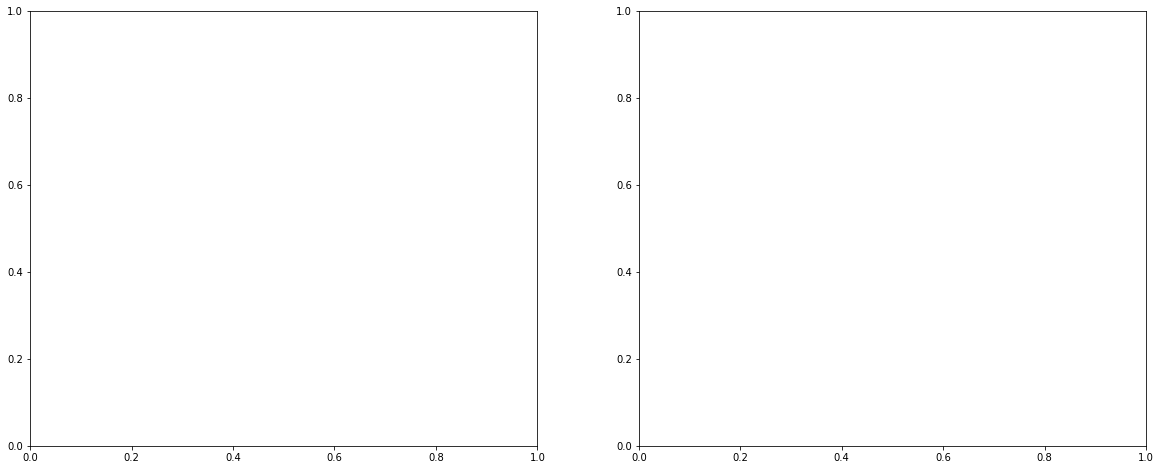

In [16]:
def train(QAgent, MCAgent, gamma, alpha,ax1,ax2):

    scores = []
    for epsilon in np.linspace(1, 0, 11):
        score = [0,0,0]
        QAgent.epsilon = epsilon
        for i in range(100):
            score[play(np.zeros((5,4)).astype(int), MCAgent, QAgent)]+=1
          
        scores.append(score)
    
    wins_final = [scores[index][1] for index in range(len(scores))]
    loss_final = [scores[index][0] for index in range(len(scores))]
    ax1.plot(np.linspace(1000, 10000, 11), wins_final, label = "Alpha="+"{:.2f}".format(alpha)+"Gamma"+"{:.2f}".format(gamma))
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Wins")
    ax1.set_title("Wins")
    ax1.legend()

    ax2.plot(np.linspace(1000, 10000, 11), loss_final, label = "Alpha="+"{:.2f}".format(alpha)+"Gamma"+"{:.2f}".format(gamma))
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Losses")
    ax2.set_title("Losses")
    ax2.legend()

gammas = np.linspace(0, 1, 4)
alphas = np.linspace(0, 1, 4)

for alpha in alphas:
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for gamma in gammas:
        agent = AfterstatesQLearningAgent(epsilon=1, gamma=gamma, alpha=alpha)
        train(agent, MonteCarloTreeSearchAgent(25), gamma, alpha,ax1, ax2)


NameError: ignored

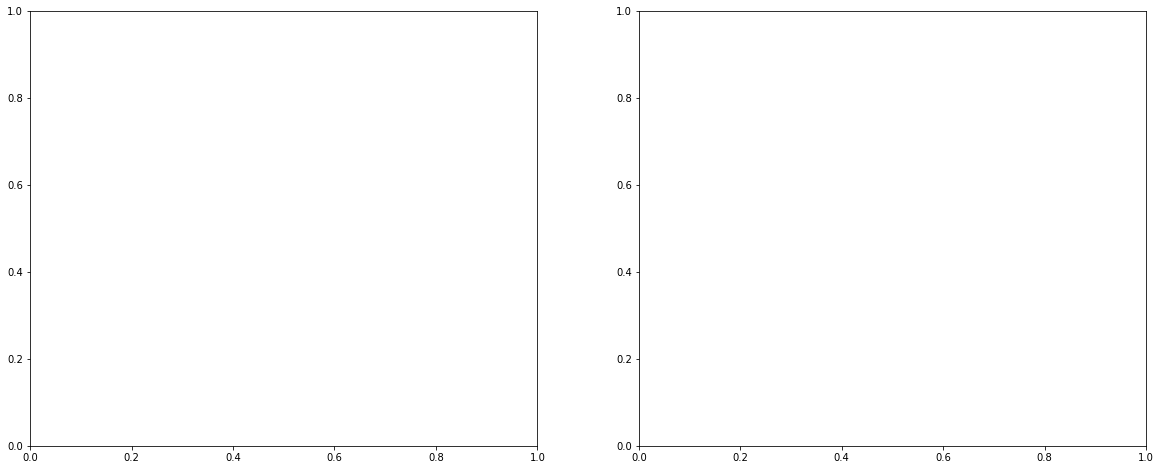

In [ ]:
def train(QAgent, MCAgent, gamma, alpha,ax1,ax2):

    scores = []
    for epsilon in np.linspace(1, 0, 11):
        score = [0,0,0]
        QAgent.epsilon = epsilon
        for i in range(100):
            score[play(np.zeros((5,4)).astype(int), MCAgent, QAgent)]+=1
          
        scores.append(score)
    
    wins_final = [scores[index][1] for index in range(len(scores))]
    loss_final = [scores[index][0] for index in range(len(scores))]
    ax1.plot(np.linspace(1000, 10000, 11), wins_final, label = "Alpha="+"{:.2f}".format(alpha)+"Gamma"+"{:.2f}".format(gamma))
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Wins")
    ax1.set_title("Wins")
    ax1.legend()

    ax2.plot(np.linspace(1000, 10000, 11), loss_final, label = "Alpha="+"{:.2f}".format(alpha)+"Gamma"+"{:.2f}".format(gamma))
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Losses")
    ax2.set_title("Losses")
    ax2.legend()

mcnums = [1, 5, 10, 15, 20 ,25]

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for mcnum in mcnums:
        agent = AfterstatesQLearningAgent(epsilon=1, gamma=gamma, alpha=alpha)
        train(agent, MonteCarloTreeSearchAgent(mcnum), gamma, alpha,ax1, ax2)